In [285]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.constants as constants

class Shock:
    def __init__(self, config=None):
        self.config = config

        self.spring_type = config["spring_type"]
        self.spring_constant = config["spring_constant"]
        self.initial_pressure = config["initial_pressure"]
        self.rider_weight = config["rider_weight"]
        self.progression_tokens = config["progression_tokens"]

        self.rebound_param = config["rebound"]
        self.HSC_param = config["HSC"]
        self.LSC_param = config["LSC"]

        self.friction = config["friction"]

        self.y0 = None
        if self.spring_type == "coil":
            self.y0 = [self.rider_weight * constants.g / self.spring_constant, 0]
        elif self.spring_type == "air":
            self.y0 = [np.sqrt(self.rider_weight * constants.g/ self.initial_pressure), 0]

    def get_model(self):
        return self.model, self.get_y0()

    def model(self, t, y, f):
        return [y[1], -self.spring(t, y[0]) +
                            -self.damping(t, y[0], y[1]) * y[1] + 
                            f(t) + constants.g]

    def get_y0(self):
        return self.y0
    
    def spring(self, t, y):

        # This is from Hooke's Law
        if self.spring_type == "coil":
            return self.config["spring_constant"] * y / self.rider_weight
        
        # This derivation comes from the ideal gas law
        elif self.spring_type == "air":
            return self.initial_pressure * y**2 / self.rider_weight
        
    # TODO : Make these functions
    def LSC(self, t, y, dy):
        if dy > 0:
            return 0
        return self.LSC_param / np.max((1, np.abs(dy)))

    def HSC(self, t, y, dy):
        if dy > 0:
            return 0
        return self.HSC_param * np.min((1, np.abs(dy)))

    def rebound(self, t, y, dy):
        if dy < 0:
            return 0
        return self.rebound_param 

    def damping(self, t, y, dy):
        return  self.LSC(t, y, dy) + self.HSC(t, y, dy) + self.rebound(t, y, dy) + self.friction 

In [286]:


class Evaluator():
    def __init__(self, shock=None):
        self.shock = shock
        self.sol = None
        # self.trail_forces = config["trail_forces"]
        # self.t_len = len(self.trail_forces)
        # self.t_eval = np.linspace(0, self.t_len, self.t_len)
        # self.t_span = (0, self.t_len)

    def set_params(self, params):
        pass

    def set_shock(self, shock):
        self.shock = shock

    def evaluate(self, trail):
        
        if self.shock is None:
            raise ValueError("Shock is not set")
        trail_forces, t_eval, t_span = trail.get_trail()


        model, y0 = self.shock.get_model()
        print(y0)
        self.sol = solve_ivp(model, t_span, y0, args=(trail_forces,), t_eval=t_eval)
        return self.sol
    
    def plot(self, trail=None):
        if self.sol is None and trail is None:
            raise ValueError("No solution to plot. Please specify a trail to evaluate")
        elif self.sol is None:
            self.evaluate(trail)

        plt.plot(self.sol.t, -self.sol.y[0], label="Shock Displacement")
        # plt.plot(self.sol.t, self.sol.y[1], label="Shock Velocity")
        # plt.plot(self.sol.t, self.sol.y[2], label="Shock Acceleration")
        plt.plot(self.sol.t, trail.trail_func(self.sol.t), label="Trail Forces")
        plt.legend()
        plt.show()
        

In [287]:
class Trail():
    def __init__(self, config=None):
        self.config = config
        self.length = config["length"]
        self.t_eval = np.array(range(self.length))
        self.t_span = (0, self.length)
        self.forces = None

    def trail_func(self, t):
        # if type(t) == np.ndarray:
        #     return np.array([self.trail_func(i) for i in t])
        # else:
        #     return 0

        return 50*np.abs(np.sin(t/10)) + 75*np.abs(np.cos(t/5))

    def create_trail(self):
        return self.trail_func
    
    def get_trail(self):
        if self.forces is None:
            self.forces = self.create_trail()
        return self.forces, self.t_eval, self.t_span

    

[5.85860691632405, 0]


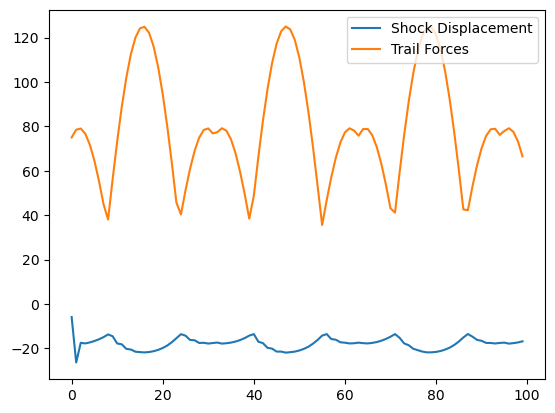

In [289]:
shock_config = {
    "spring_type": "air",
    "spring_constant": 11, # 5 N/m
    "initial_pressure": 10,
    "rider_weight": 35, 
    "progression_tokens": 0,
    "rebound": 0,
    "HSC": 4,
    "LSC": 4,
    "friction": 0.1
}

trail_config = {
    "length": 100
}

shock = Shock(shock_config)
evaluator = Evaluator(shock)
trail = Trail(trail_config)

evaluator.plot(trail)